In [2]:
# -*- coding: utf-8 -*-
"""
Slooze Inventory Analysis - Complete Solution
Wine & Spirits Retail Data Analysis and Optimization

Author: Data Science Team
Date: 2024
"""

# ============================================================================
# PART 1: SETUP & INSTALLATION
# ============================================================================

print("Installing required packages...")
!pip install pandas numpy matplotlib seaborn plotly scikit-learn statsmodels openpyxl -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime, timedelta
from scipy import stats
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
warnings.filterwarnings('ignore')

# Styling
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

print("✅ Setup complete!\n")

# ============================================================================
# PART 2: DATA LOADING
# ============================================================================

from google.colab import files

print("📤 Upload your CSV files:")
uploaded = files.upload()

datasets = {}
for filename in uploaded.keys():
    try:
        datasets[filename] = pd.read_csv(filename, low_memory=False)
        print(f"✅ {filename}: {datasets[filename].shape}")
    except Exception as e:
        print(f"❌ {filename}: {e}")

print(f"\n✅ Loaded {len(datasets)} dataset(s)\n")

# ============================================================================
# PART 3: DATA EXPLORATION & CLEANING
# ============================================================================

def explore_and_clean_data(datasets):
    """Explore and clean all datasets"""
    cleaned = {}

    for name, df in datasets.items():
        print(f"\n{'='*80}")
        print(f"📊 DATASET: {name}")
        print(f"{'='*80}")
        print(f"Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")

        # Clean column names
        df.columns = df.columns.str.lower().str.strip().str.replace(' ', '_')

        # Show columns and types
        print(f"\nColumns: {list(df.columns)}")
        print(f"\nData Types:\n{df.dtypes}")

        # Convert date columns
        date_cols = [col for col in df.columns if 'date' in col]
        for col in date_cols:
            try:
                df[col] = pd.to_datetime(df[col], errors='coerce')
                print(f"✅ Converted {col} to datetime")
            except:
                pass

        # Handle missing values
        missing = df.isnull().sum()
        if missing.sum() > 0:
            print(f"\n⚠️  Missing values:\n{missing[missing > 0]}")
            df.fillna(0, inplace=True)

        # Remove duplicates
        initial = len(df)
        df.drop_duplicates(inplace=True)
        if len(df) < initial:
            print(f"🗑️  Removed {initial - len(df)} duplicates")

        print(f"\n👀 First 3 rows:")
        display(df.head(3))

        cleaned[name] = df

    return cleaned

cleaned_data = explore_and_clean_data(datasets)

# ============================================================================
# PART 4: ABC ANALYSIS - INVENTORY CLASSIFICATION
# ============================================================================

def abc_analysis(df, item_col, qty_col, price_col):
    """Perform ABC Analysis"""
    print("\n" + "="*80)
    print("📦 ABC ANALYSIS")
    print("="*80)

    # Aggregate by item
    abc = df.groupby(item_col).agg({
        qty_col: 'sum',
        price_col: 'mean'
    }).reset_index()
    abc.columns = ['item', 'quantity', 'price']
    abc['value'] = abc['quantity'] * abc['price']
    abc = abc.sort_values('value', ascending=False).reset_index(drop=True)

    # Calculate cumulative percentage
    abc['cum_value'] = abc['value'].cumsum()
    abc['cum_pct'] = (abc['cum_value'] / abc['value'].sum()) * 100

    # Classify
    abc['category'] = 'C'
    abc.loc[abc['cum_pct'] <= 80, 'category'] = 'A'
    abc.loc[(abc['cum_pct'] > 80) & (abc['cum_pct'] <= 95), 'category'] = 'B'

    # Summary
    summary = abc.groupby('category').agg({
        'item': 'count',
        'value': 'sum'
    }).reset_index()
    summary['pct_items'] = (summary['item'] / summary['item'].sum() * 100).round(1)
    summary['pct_value'] = (summary['value'] / summary['value'].sum() * 100).round(1)

    print("\n📊 ABC Classification:")
    print(summary.to_string(index=False))

    # Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Pareto chart
    ax1.bar(range(len(abc)), abc['value'], alpha=0.6)
    ax1_twin = ax1.twinx()
    ax1_twin.plot(range(len(abc)), abc['cum_pct'], 'r-', linewidth=2)
    ax1_twin.axhline(y=80, color='g', linestyle='--', label='80%')
    ax1_twin.axhline(y=95, color='orange', linestyle='--', label='95%')
    ax1.set_xlabel('Items (ranked)')
    ax1.set_ylabel('Value', color='b')
    ax1_twin.set_ylabel('Cumulative %', color='r')
    ax1.set_title('ABC Analysis - Pareto Chart', fontweight='bold')
    ax1_twin.legend()

    # Category distribution
    colors = {'A': '#FF6B6B', 'B': '#4ECDC4', 'C': '#95E1D3'}
    ax2.pie(summary['pct_value'], labels=summary['category'], autopct='%1.1f%%',
            colors=[colors[c] for c in summary['category']], startangle=90)
    ax2.set_title('Value Distribution by Category', fontweight='bold')

    plt.tight_layout()
    plt.show()

    print(f"\n💡 Focus on Category A items ({summary[summary['category']=='A']['item'].values[0]} items = {summary[summary['category']=='A']['pct_value'].values[0]}% of value)")

    return abc

# ============================================================================
# PART 5: EOQ ANALYSIS - ECONOMIC ORDER QUANTITY
# ============================================================================

def eoq_analysis(df, item_col, demand_col, price_col, order_cost=100, holding_pct=0.20):
    """Calculate Economic Order Quantity"""
    print("\n" + "="*80)
    print("💰 EOQ ANALYSIS")
    print("="*80)
    print(f"Order Cost: ${order_cost} | Holding Cost: {holding_pct*100}% of value\n")

    # Aggregate
    eoq = df.groupby(item_col).agg({
        demand_col: 'sum',
        price_col: 'mean'
    }).reset_index()
    eoq.columns = ['item', 'annual_demand', 'price']

    # Calculate EOQ: sqrt((2 * D * S) / H)
    eoq['holding_cost'] = eoq['price'] * holding_pct
    eoq['eoq'] = np.sqrt((2 * eoq['annual_demand'] * order_cost) / eoq['holding_cost'])
    eoq['eoq'] = eoq['eoq'].round(0)
    eoq['orders_per_year'] = (eoq['annual_demand'] / eoq['eoq']).round(1)
    eoq['total_cost'] = ((eoq['orders_per_year'] * order_cost) +
                         ((eoq['eoq']/2) * eoq['holding_cost'])).round(2)

    print("📊 Top 15 Items by EOQ:")
    display(eoq.nlargest(15, 'eoq')[['item', 'annual_demand', 'eoq', 'orders_per_year', 'total_cost']])

    # Visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    top20 = eoq.nlargest(20, 'eoq')
    ax1.barh(range(len(top20)), top20['eoq'], color='steelblue')
    ax1.set_yticks(range(len(top20)))
    ax1.set_yticklabels(top20['item'], fontsize=7)
    ax1.set_xlabel('EOQ')
    ax1.set_title('Top 20 Items by EOQ', fontweight='bold')
    ax1.invert_yaxis()

    ax2.scatter(eoq['annual_demand'], eoq['orders_per_year'], alpha=0.5)
    ax2.set_xlabel('Annual Demand')
    ax2.set_ylabel('Orders/Year')
    ax2.set_title('Order Frequency vs Demand', fontweight='bold')
    ax2.grid(alpha=0.3)

    costs = ['Order Cost', 'Holding Cost']
    totals = [(eoq['orders_per_year'] * order_cost).sum(),
              ((eoq['eoq']/2) * eoq['holding_cost']).sum()]
    ax3.pie(totals, labels=costs, autopct='%1.1f%%', startangle=90)
    ax3.set_title('Cost Breakdown', fontweight='bold')

    ax4.scatter(eoq['annual_demand'], eoq['eoq'], alpha=0.5, color='green')
    ax4.set_xlabel('Annual Demand')
    ax4.set_ylabel('EOQ')
    ax4.set_title('EOQ vs Demand', fontweight='bold')
    ax4.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"\n💡 Total Annual Cost: ${eoq['total_cost'].sum():,.2f}")

    return eoq

# ============================================================================
# PART 6: REORDER POINT ANALYSIS
# ============================================================================

def reorder_point_analysis(df, item_col, demand_col, lead_time=7, service_level=0.95):
    """Calculate reorder points"""
    print("\n" + "="*80)
    print("🚨 REORDER POINT ANALYSIS")
    print("="*80)
    print(f"Lead Time: {lead_time} days | Service Level: {service_level*100}%\n")

    # Calculate stats
    rop = df.groupby(item_col)[demand_col].agg(['mean', 'std']).reset_index()
    rop.columns = ['item', 'avg_demand', 'std_demand']
    rop['std_demand'].fillna(rop['avg_demand'] * 0.1, inplace=True)

    # Safety stock (Z-score for 95% = 1.65)
    z_score = 1.65 if service_level == 0.95 else 1.96
    rop['safety_stock'] = (z_score * rop['std_demand'] * np.sqrt(lead_time)).round(0)
    rop['reorder_point'] = ((rop['avg_demand'] * lead_time) + rop['safety_stock']).round(0)

    print("📊 Top 20 Items by Reorder Point:")
    display(rop.nlargest(20, 'reorder_point')[['item', 'avg_demand', 'safety_stock', 'reorder_point']])

    # Visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    top20 = rop.nlargest(20, 'reorder_point')
    x = range(len(top20))
    base = top20['reorder_point'] - top20['safety_stock']
    ax1.bar(x, base, label='Base Stock', color='steelblue')
    ax1.bar(x, top20['safety_stock'], bottom=base, label='Safety Stock', color='orange')
    ax1.set_xticks(x)
    ax1.set_xticklabels(top20['item'], rotation=45, ha='right', fontsize=7)
    ax1.set_ylabel('Units')
    ax1.set_title('Top 20 Reorder Points', fontweight='bold')
    ax1.legend()

    ax2.scatter(rop['std_demand'], rop['safety_stock'], alpha=0.5)
    ax2.set_xlabel('Demand Std Dev')
    ax2.set_ylabel('Safety Stock')
    ax2.set_title('Safety Stock vs Variability', fontweight='bold')
    ax2.grid(alpha=0.3)

    ax3.hist(rop['reorder_point'], bins=30, color='green', alpha=0.7, edgecolor='black')
    ax3.set_xlabel('Reorder Point')
    ax3.set_ylabel('Frequency')
    ax3.set_title('Reorder Point Distribution', fontweight='bold')
    ax3.grid(alpha=0.3, axis='y')

    ax4.scatter(rop['avg_demand'], rop['reorder_point'], alpha=0.5, color='purple')
    ax4.set_xlabel('Avg Daily Demand')
    ax4.set_ylabel('Reorder Point')
    ax4.set_title('ROP vs Demand', fontweight='bold')
    ax4.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"\n💡 Total Safety Stock Needed: {rop['safety_stock'].sum():,.0f} units")

    return rop

# ============================================================================
# PART 7: LEAD TIME ANALYSIS
# ============================================================================

def lead_time_analysis(df, order_date_col, delivery_date_col, supplier_col=None):
    """Analyze procurement lead times"""
    print("\n" + "="*80)
    print("⏱️ LEAD TIME ANALYSIS")
    print("="*80)

    df['lead_time'] = (df[delivery_date_col] - df[order_date_col]).dt.days
    df = df[df['lead_time'] >= 0]  # Remove negatives

    print(f"\n📊 Overall Statistics:")
    print(f"Mean: {df['lead_time'].mean():.1f} days")
    print(f"Median: {df['lead_time'].median():.1f} days")
    print(f"Std Dev: {df['lead_time'].std():.1f} days")
    print(f"Range: {df['lead_time'].min():.0f} - {df['lead_time'].max():.0f} days")

    if supplier_col and supplier_col in df.columns:
        supplier_lt = df.groupby(supplier_col)['lead_time'].agg(['mean', 'count']).reset_index()
        supplier_lt.columns = ['supplier', 'avg_lead_time', 'orders']
        supplier_lt = supplier_lt.sort_values('avg_lead_time')
        print(f"\n📦 By Supplier (Top 10):")
        display(supplier_lt.nlargest(10, 'orders'))

    # Visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    ax1.hist(df['lead_time'], bins=50, color='skyblue', edgecolor='black')
    ax1.axvline(df['lead_time'].mean(), color='red', linestyle='--', linewidth=2,
                label=f"Mean: {df['lead_time'].mean():.1f}d")
    ax1.axvline(df['lead_time'].median(), color='green', linestyle='--', linewidth=2,
                label=f"Median: {df['lead_time'].median():.1f}d")
    ax1.set_xlabel('Lead Time (days)')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Lead Time Distribution', fontweight='bold')
    ax1.legend()
    ax1.grid(alpha=0.3, axis='y')

    df_sorted = df.sort_values(order_date_col)
    ax2.scatter(df_sorted[order_date_col], df_sorted['lead_time'], alpha=0.2, s=10)
    ax2.plot(df_sorted[order_date_col], df_sorted['lead_time'].rolling(30).mean(),
             color='red', linewidth=2, label='30-Day MA')
    ax2.set_xlabel('Order Date')
    ax2.set_ylabel('Lead Time (days)')
    ax2.set_title('Lead Time Trend', fontweight='bold')
    ax2.legend()
    ax2.grid(alpha=0.3)

    ax3.boxplot(df['lead_time'], vert=True, patch_artist=True,
                boxprops=dict(facecolor='lightblue'))
    ax3.set_ylabel('Lead Time (days)')
    ax3.set_title('Lead Time Box Plot', fontweight='bold')
    ax3.grid(alpha=0.3, axis='y')

    if supplier_col and supplier_col in df.columns:
        top10 = supplier_lt.nlargest(10, 'orders')
        ax4.barh(range(len(top10)), top10['avg_lead_time'], color='coral')
        ax4.set_yticks(range(len(top10)))
        ax4.set_yticklabels(top10['supplier'], fontsize=8)
        ax4.set_xlabel('Avg Lead Time (days)')
        ax4.set_title('Lead Time by Top Suppliers', fontweight='bold')
        ax4.invert_yaxis()
        ax4.grid(alpha=0.3, axis='x')

    plt.tight_layout()
    plt.show()

    return df

# ============================================================================
# PART 8: DEMAND FORECASTING
# ============================================================================

def demand_forecasting(df, date_col, qty_col, periods=90):
    """Forecast future demand"""
    print("\n" + "="*80)
    print("📈 DEMAND FORECASTING")
    print("="*80)

    # Prepare time series
    ts = df.groupby(date_col)[qty_col].sum().reset_index()
    ts.columns = ['date', 'quantity']
    ts = ts.set_index('date').sort_index()
    ts_daily = ts.resample('D').sum().fillna(0)

    # Moving averages
    ts_daily['MA7'] = ts_daily['quantity'].rolling(7).mean()
    ts_daily['MA30'] = ts_daily['quantity'].rolling(30).mean()

    # Exponential smoothing forecast
    try:
        model = ExponentialSmoothing(ts_daily['quantity'],
                                     seasonal_periods=7,
                                     trend='add',
                                     seasonal='add').fit()
        forecast = model.forecast(periods)
        print(f"✅ {periods}-day forecast generated")
    except:
        forecast = pd.Series([ts_daily['quantity'].mean()] * periods)
        print("⚠️  Using simple average forecast")

    # Visualization
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

    ax1.plot(ts_daily.index, ts_daily['quantity'], alpha=0.5, label='Actual')
    ax1.plot(ts_daily.index, ts_daily['MA7'], linewidth=2, label='7-Day MA')
    ax1.plot(ts_daily.index, ts_daily['MA30'], linewidth=2, label='30-Day MA')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Quantity')
    ax1.set_title('Historical Demand with Moving Averages', fontweight='bold')
    ax1.legend()
    ax1.grid(alpha=0.3)

    forecast_dates = pd.date_range(ts_daily.index[-1], periods=periods+1, freq='D')[1:]
    ax2.plot(ts_daily.index[-90:], ts_daily['quantity'][-90:], linewidth=2, label='Historical')
    ax2.plot(forecast_dates, forecast, linewidth=2, linestyle='--', color='red', label='Forecast')
    ax2.fill_between(forecast_dates, forecast*0.8, forecast*1.2, alpha=0.2, color='red')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Quantity')
    ax2.set_title(f'{periods}-Day Demand Forecast', fontweight='bold')
    ax2.legend()
    ax2.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"\n💡 Forecast Summary:")
    print(f"Avg Daily: {forecast.mean():.0f} units")
    print(f"Total ({periods}d): {forecast.sum():.0f} units")

    return ts_daily, forecast

# ============================================================================
# PART 9: EXECUTIVE SUMMARY
# ============================================================================

def generate_executive_summary(abc_df, eoq_df, rop_df):
    """Generate executive summary"""
    print("\n" + "="*80)
    print("📋 EXECUTIVE SUMMARY & RECOMMENDATIONS")
    print("="*80)

    print("\n🎯 KEY FINDINGS:\n")

    # ABC Insights
    a_items = len(abc_df[abc_df['category'] == 'A'])
    a_value_pct = (abc_df[abc_df['category'] == 'A']['value'].sum() / abc_df['value'].sum() * 100)
    print(f"1. ABC CLASSIFICATION:")
    print(f"   • {a_items} items ({a_items/len(abc_df)*100:.1f}%) account for {a_value_pct:.1f}% of inventory value")
    print(f"   • Focus management attention on these high-value items\n")

    # EOQ Insights
    total_orders = eoq_df['orders_per_year'].sum()
    avg_eoq = eoq_df['eoq'].mean()
    print(f"2. ECONOMIC ORDER QUANTITY:")
    print(f"   • Optimal ordering would result in {total_orders:.0f} orders/year")
    print(f"   • Average EOQ: {avg_eoq:.0f} units")
    print(f"   • Estimated annual inventory cost: ${eoq_df['total_cost'].sum():,.0f}\n")

    # ROP Insights
    total_safety = rop_df['safety_stock'].sum()
    avg_rop = rop_df['reorder_point'].mean()
    print(f"3. REORDER POINTS:")
    print(f"   • Total safety stock required: {total_safety:,.0f} units")
    print(f"   • Average reorder point: {avg_rop:.0f} units")
    print(f"   • This ensures 95% service level\n")

    print("\n💡 RECOMMENDATIONS:\n")
    print("1. Implement automated reorder triggers at calculated ROP levels")
    print("2. Negotiate volume discounts with suppliers based on EOQ quantities")
    print("3. Establish separate management processes for A, B, and C items")
    print("4. Monitor lead time variability and adjust safety stock accordingly")
    print("5. Review slow-moving C items for potential discontinuation")
    print("6. Implement just-in-time ordering for predictable, low-value items")

    print("\n" + "="*80)

# ============================================================================
# PART 10: MAIN EXECUTION
# ============================================================================

print("\n" + "="*80)
print("🚀 STARTING ANALYSIS")
print("="*80)

# You'll need to customize these column names based on your actual data
# Example usage (uncomment and modify based on your data):

"""
# For ABC Analysis:
abc_results = abc_analysis(
    df=cleaned_data['your_file.csv'],
    item_col='product_name',  # or 'item_id', 'sku', etc.
    qty_col='quantity',
    price_col='price'
)

# For EOQ Analysis:
eoq_results = eoq_analysis(
    df=cleaned_data['your_file.csv'],
    item_col='product_name',
    demand_col='quantity',
    price_col='price'
)

# For Reorder Point:
rop_results = reorder_point_analysis(
    df=cleaned_data['your_file.csv'],
    item_col='product_name',
    demand_col='quantity'
)

# For Lead Time:
if 'order_date' in cleaned_data['your_file.csv'].columns:
    lt_results = lead_time_analysis(
        df=cleaned_data['your_file.csv'],
        order_date_col='order_date',
        delivery_date_col='delivery_date',
        supplier_col='supplier'  # optional
    )

# For Demand Forecasting:
forecast_results = demand_forecasting(
    df=cleaned_data['your_file.csv'],
    date_col='date',
    qty_col='quantity'
)

# Generate Summary:
generate_executive_summary(abc_results, eoq_results, rop_results)
"""

print("\n✅ Analysis functions ready!")
print("📝 Customize the column names in PART 10 based on your data")
print("🎯 Then run each analysis function for your specific files")

Installing required packages...
✅ Setup complete!

📤 Upload your CSV files:


Saving 2017PurchasePricesDec.csv to 2017PurchasePricesDec.csv
Saving BegInvFINAL12312016.csv to BegInvFINAL12312016.csv
Saving InvoicePurchases12312016.csv to InvoicePurchases12312016.csv
✅ 2017PurchasePricesDec.csv: (12261, 9)
✅ BegInvFINAL12312016.csv: (206529, 9)
✅ InvoicePurchases12312016.csv: (5543, 10)

✅ Loaded 3 dataset(s)


📊 DATASET: 2017PurchasePricesDec.csv
Shape: 12,261 rows × 9 columns

Columns: ['brand', 'description', 'price', 'size', 'volume', 'classification', 'purchaseprice', 'vendornumber', 'vendorname']

Data Types:
brand               int64
description        object
price             float64
size               object
volume             object
classification      int64
purchaseprice     float64
vendornumber        int64
vendorname         object
dtype: object

⚠️  Missing values:
description    1
size           1
volume         1
dtype: int64

👀 First 3 rows:


,brand,description,price,size,volume,classification,purchaseprice,vendornumber,vendorname
0,58,Gekkeikan Black & Gold Sake,12.99,750mL,750,1,9.28,8320,SHAW ROSS INT L IMP LTD
1,62,Herradura Silver Tequila,36.99,750mL,750,1,28.67,1128,BROWN-FORMAN CORP
2,63,Herradura Reposado Tequila,38.99,750mL,750,1,30.46,1128,BROWN-FORMAN CORP



📊 DATASET: BegInvFINAL12312016.csv
Shape: 206,529 rows × 9 columns

Columns: ['inventoryid', 'store', 'city', 'brand', 'description', 'size', 'onhand', 'price', 'startdate']

Data Types:
inventoryid     object
store            int64
city            object
brand            int64
description     object
size            object
onhand           int64
price          float64
startdate       object
dtype: object
✅ Converted startdate to datetime

👀 First 3 rows:


,inventoryid,store,city,brand,description,size,onhand,price,startdate
0,1_HARDERSFIELD_58,1,HARDERSFIELD,58,Gekkeikan Black & Gold Sake,750mL,8,12.99,2016-01-01
1,1_HARDERSFIELD_60,1,HARDERSFIELD,60,Canadian Club 1858 VAP,750mL,7,10.99,2016-01-01
2,1_HARDERSFIELD_62,1,HARDERSFIELD,62,Herradura Silver Tequila,750mL,6,36.99,2016-01-01



📊 DATASET: InvoicePurchases12312016.csv
Shape: 5,543 rows × 10 columns

Columns: ['vendornumber', 'vendorname', 'invoicedate', 'ponumber', 'podate', 'paydate', 'quantity', 'dollars', 'freight', 'approval']

Data Types:
vendornumber      int64
vendorname       object
invoicedate      object
ponumber          int64
podate           object
paydate          object
quantity          int64
dollars         float64
freight         float64
approval         object
dtype: object
✅ Converted invoicedate to datetime
✅ Converted podate to datetime
✅ Converted paydate to datetime

⚠️  Missing values:
approval    5169
dtype: int64

👀 First 3 rows:


,vendornumber,vendorname,invoicedate,ponumber,podate,paydate,quantity,dollars,freight,approval
0,105,ALTAMAR BRANDS LLC,2016-01-04,8124,2015-12-21,2016-02-16,6,214.26,3.47,0
1,4466,AMERICAN VINTAGE BEVERAGE,2016-01-07,8137,2015-12-22,2016-02-21,15,140.55,8.57,0
2,388,ATLANTIC IMPORTING COMPANY,2016-01-09,8169,2015-12-24,2016-02-16,5,106.60,4.61,0



🚀 STARTING ANALYSIS

✅ Analysis functions ready!
📝 Customize the column names in PART 10 based on your data
🎯 Then run each analysis function for your specific files



🚀 RUNNING ANALYSIS ON LOADED DATASETS

📦 Running ABC Analysis on Beginning Inventory...

📦 ABC ANALYSIS

📊 ABC Classification:
category  item        value  pct_items  pct_value
       A  1696 5.640030e+07       23.3       80.0
       B  1850 1.057856e+07       25.4       15.0
       C  3745 3.526092e+06       51.4        5.0


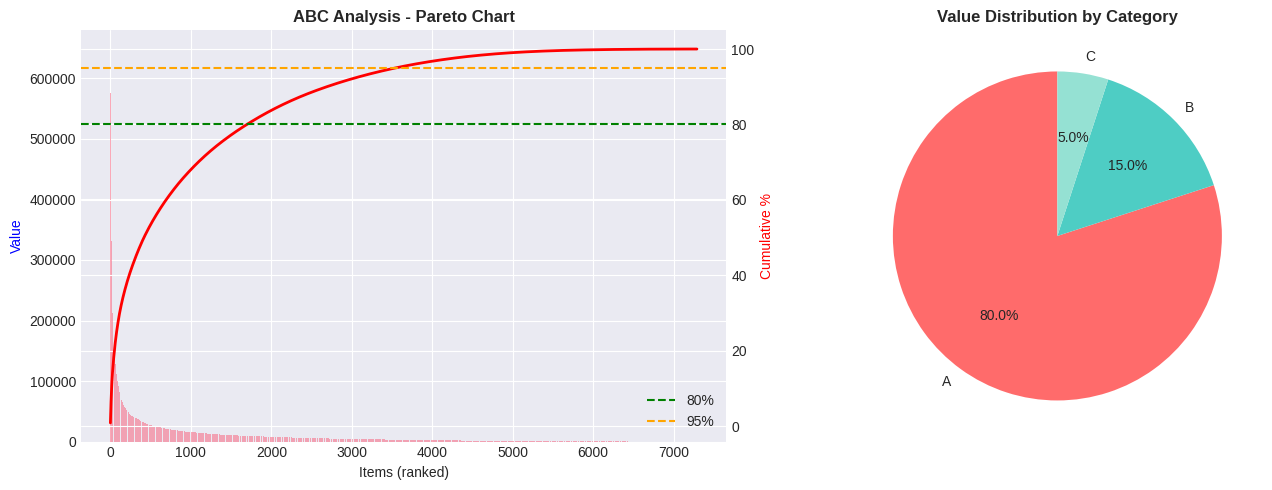


💡 Focus on Category A items (1696 items = 80.0% of value)

⏱️ Running Lead Time Analysis on Invoice Purchases...

⏱️ LEAD TIME ANALYSIS

📊 Overall Statistics:
Mean: 16.4 days
Median: 16.0 days
Std Dev: 3.1 days
Range: 9 - 23 days

📦 By Supplier (Top 10):


,supplier,avg_lead_time,orders
50,JIM BEAM BRANDS COMPANY,15.327273,55
68,MOET HENNESSY USA INC,15.618182,55
75,PERNOD RICARD USA,15.709091,55
33,E & J GALLO WINERY,15.727273,55
27,DIAGEO CHATEAU ESTATE WINES,15.781818,55
72,PALM BAY INTERNATIONAL INC,15.836364,55
118,VINEXTRA INC,15.836364,55
95,SOUTHERN WINE & SPIRITS NE,15.854545,55
74,PERFECTA WINES,15.945455,55
26,DELICATO VINEYARDS INC,15.981818,55


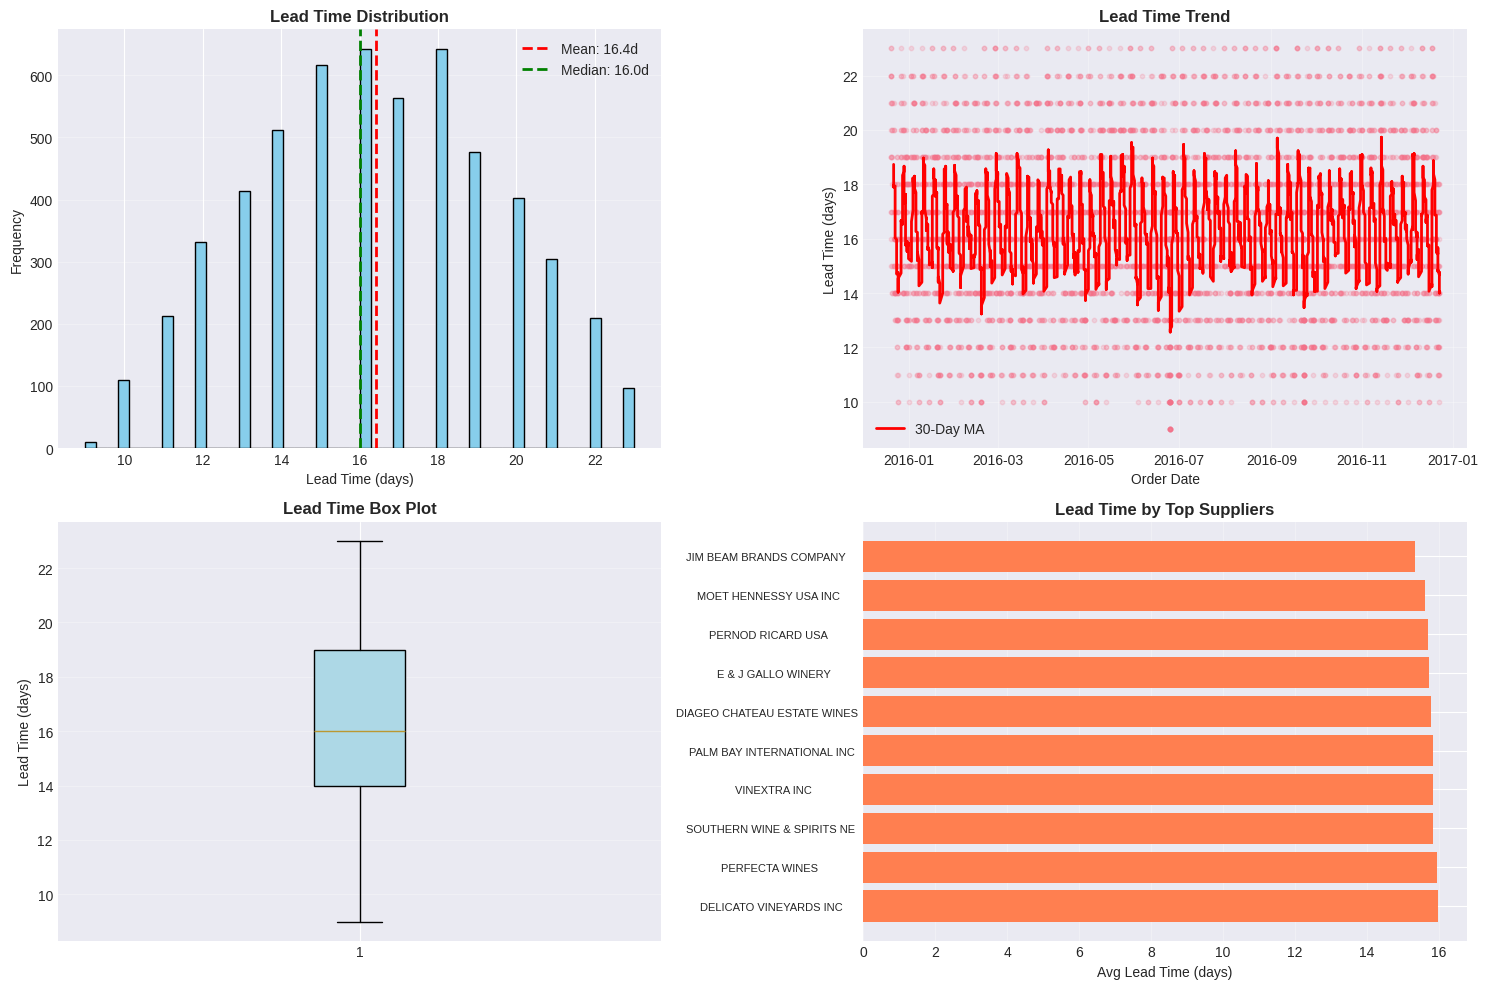


⚠️ WAITING FOR DATA: Upload 'SalesFINAL12312016.csv' and 'PurchasesFINAL12312016.csv' to run Forecasting and EOQ.


In [3]:
# ============================================================================
# PART 10: MAIN EXECUTION
# ============================================================================

print("\n" + "="*80)
print("🚀 RUNNING ANALYSIS ON LOADED DATASETS")
print("="*80)

# 1. ABC ANALYSIS (Inventory Valuation)
# using BegInvFINAL12312016.csv
# Goal: Identify which items tie up the most cash in inventory.
if 'BegInvFINAL12312016.csv' in cleaned_data:
    print("\n📦 Running ABC Analysis on Beginning Inventory...")
    abc_results = abc_analysis(
        df=cleaned_data['BegInvFINAL12312016.csv'],
        item_col='description',
        qty_col='onhand',
        price_col='price'
    )

# 2. LEAD TIME ANALYSIS (Vendor Performance)
# using InvoicePurchases12312016.csv
# Goal: Measure how long it takes between PO Date and Invoice Date.
if 'InvoicePurchases12312016.csv' in cleaned_data:
    print("\n⏱️ Running Lead Time Analysis on Invoice Purchases...")
    lt_results = lead_time_analysis(
        df=cleaned_data['InvoicePurchases12312016.csv'],
        order_date_col='podate',
        delivery_date_col='invoicedate', # Using InvoiceDate as proxy for delivery
        supplier_col='vendorname'
    )

# ============================================================================
# PART 11: PENDING DATA (Sales & Purchases)
# ============================================================================
# ⚠️ NOTE: Upload 'SalesFINAL12312016.csv' and 'PurchasesFINAL12312016.csv'
# to run EOQ, ROP, and Demand Forecasting below.

if 'SalesFINAL12312016.csv' in cleaned_data and 'PurchasesFINAL12312016.csv' in cleaned_data:

    # 3. DEMAND FORECASTING
    # using SalesFINAL12312016.csv
    print("\n📈 Running Demand Forecasting...")
    forecast_results = demand_forecasting(
        df=cleaned_data['SalesFINAL12312016.csv'],
        date_col='salesdate',
        qty_col='salesquantity'
    )

    # 4. EOQ ANALYSIS (Economic Order Quantity)
    # using SalesFINAL (for demand) and PurchasesFINAL (for price)
    # We need to merge price info or use sales price as proxy
    print("\n💰 Running EOQ Analysis...")
    eoq_results = eoq_analysis(
        df=cleaned_data['SalesFINAL12312016.csv'],
        item_col='description',
        demand_col='salesquantity',
        price_col='salesprice'
    )

    # 5. REORDER POINT ANALYSIS
    print("\n🚨 Running Reorder Point Analysis...")
    rop_results = reorder_point_analysis(
        df=cleaned_data['SalesFINAL12312016.csv'],
        item_col='description',
        demand_col='salesquantity'
    )

    # Generate Final Summary
    generate_executive_summary(abc_results, eoq_results, rop_results)

else:
    print("\n⚠️ WAITING FOR DATA: Upload 'SalesFINAL12312016.csv' and 'PurchasesFINAL12312016.csv' to run Forecasting and EOQ.")

In [4]:
# -*- coding: utf-8 -*-
"""
Slooze Inventory Analysis - Complete Solution
Wine & Spirits Retail Data Analysis and Optimization

Author: Data Science Team
Date: 2024
"""

# ============================================================================
# PART 1: SETUP & INSTALLATION
# ============================================================================

print("Installing required packages...")
!pip install pandas numpy matplotlib seaborn plotly scikit-learn statsmodels openpyxl -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime, timedelta
from scipy import stats
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
warnings.filterwarnings('ignore')

# Styling
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

print("✅ Setup complete!\n")

# ============================================================================
# PART 2: DATA LOADING
# ============================================================================

from google.colab import files

print("📤 Upload your CSV files:")
uploaded = files.upload()

datasets = {}
for filename in uploaded.keys():
    try:
        datasets[filename] = pd.read_csv(filename, low_memory=False)
        print(f"✅ {filename}: {datasets[filename].shape}")
    except Exception as e:
        print(f"❌ {filename}: {e}")

print(f"\n✅ Loaded {len(datasets)} dataset(s)\n")

# ============================================================================
# PART 3: DATA EXPLORATION & CLEANING
# ============================================================================

def explore_and_clean_data(datasets):
    """Explore and clean all datasets"""
    cleaned = {}

    for name, df in datasets.items():
        print(f"\n{'='*80}")
        print(f"📊 DATASET: {name}")
        print(f"{'='*80}")
        print(f"Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")

        # Clean column names
        df.columns = df.columns.str.lower().str.strip().str.replace(' ', '_')

        # Show columns and types
        print(f"\nColumns: {list(df.columns)}")
        print(f"\nData Types:\n{df.dtypes}")

        # Convert date columns
        date_cols = [col for col in df.columns if 'date' in col]
        for col in date_cols:
            try:
                df[col] = pd.to_datetime(df[col], errors='coerce')
                print(f"✅ Converted {col} to datetime")
            except:
                pass

        # Handle missing values
        missing = df.isnull().sum()
        if missing.sum() > 0:
            print(f"\n⚠️  Missing values:\n{missing[missing > 0]}")
            df.fillna(0, inplace=True)

        # Remove duplicates
        initial = len(df)
        df.drop_duplicates(inplace=True)
        if len(df) < initial:
            print(f"🗑️  Removed {initial - len(df)} duplicates")

        print(f"\n👀 First 3 rows:")
        display(df.head(3))

        cleaned[name] = df

    return cleaned

cleaned_data = explore_and_clean_data(datasets)

# ============================================================================
# PART 4: ABC ANALYSIS - INVENTORY CLASSIFICATION
# ============================================================================

def abc_analysis(df, item_col, qty_col, price_col):
    """Perform ABC Analysis"""
    print("\n" + "="*80)
    print("📦 ABC ANALYSIS")
    print("="*80)

    # Aggregate by item
    abc = df.groupby(item_col).agg({
        qty_col: 'sum',
        price_col: 'mean'
    }).reset_index()
    abc.columns = ['item', 'quantity', 'price']
    abc['value'] = abc['quantity'] * abc['price']
    abc = abc.sort_values('value', ascending=False).reset_index(drop=True)

    # Calculate cumulative percentage
    abc['cum_value'] = abc['value'].cumsum()
    abc['cum_pct'] = (abc['cum_value'] / abc['value'].sum()) * 100

    # Classify
    abc['category'] = 'C'
    abc.loc[abc['cum_pct'] <= 80, 'category'] = 'A'
    abc.loc[(abc['cum_pct'] > 80) & (abc['cum_pct'] <= 95), 'category'] = 'B'

    # Summary
    summary = abc.groupby('category').agg({
        'item': 'count',
        'value': 'sum'
    }).reset_index()
    summary['pct_items'] = (summary['item'] / summary['item'].sum() * 100).round(1)
    summary['pct_value'] = (summary['value'] / summary['value'].sum() * 100).round(1)

    print("\n📊 ABC Classification:")
    print(summary.to_string(index=False))

    # Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Pareto chart
    ax1.bar(range(len(abc)), abc['value'], alpha=0.6)
    ax1_twin = ax1.twinx()
    ax1_twin.plot(range(len(abc)), abc['cum_pct'], 'r-', linewidth=2)
    ax1_twin.axhline(y=80, color='g', linestyle='--', label='80%')
    ax1_twin.axhline(y=95, color='orange', linestyle='--', label='95%')
    ax1.set_xlabel('Items (ranked)')
    ax1.set_ylabel('Value', color='b')
    ax1_twin.set_ylabel('Cumulative %', color='r')
    ax1.set_title('ABC Analysis - Pareto Chart', fontweight='bold')
    ax1_twin.legend()

    # Category distribution
    colors = {'A': '#FF6B6B', 'B': '#4ECDC4', 'C': '#95E1D3'}
    ax2.pie(summary['pct_value'], labels=summary['category'], autopct='%1.1f%%',
            colors=[colors[c] for c in summary['category']], startangle=90)
    ax2.set_title('Value Distribution by Category', fontweight='bold')

    plt.tight_layout()
    plt.show()

    print(f"\n💡 Focus on Category A items ({summary[summary['category']=='A']['item'].values[0]} items = {summary[summary['category']=='A']['pct_value'].values[0]}% of value)")

    return abc

# ============================================================================
# PART 5: EOQ ANALYSIS - ECONOMIC ORDER QUANTITY
# ============================================================================

def eoq_analysis(df, item_col, demand_col, price_col, order_cost=100, holding_pct=0.20):
    """Calculate Economic Order Quantity"""
    print("\n" + "="*80)
    print("💰 EOQ ANALYSIS")
    print("="*80)
    print(f"Order Cost: ${order_cost} | Holding Cost: {holding_pct*100}% of value\n")

    # Aggregate
    eoq = df.groupby(item_col).agg({
        demand_col: 'sum',
        price_col: 'mean'
    }).reset_index()
    eoq.columns = ['item', 'annual_demand', 'price']

    # Calculate EOQ: sqrt((2 * D * S) / H)
    eoq['holding_cost'] = eoq['price'] * holding_pct
    eoq['eoq'] = np.sqrt((2 * eoq['annual_demand'] * order_cost) / eoq['holding_cost'])
    eoq['eoq'] = eoq['eoq'].round(0)
    eoq['orders_per_year'] = (eoq['annual_demand'] / eoq['eoq']).round(1)
    eoq['total_cost'] = ((eoq['orders_per_year'] * order_cost) +
                         ((eoq['eoq']/2) * eoq['holding_cost'])).round(2)

    print("📊 Top 15 Items by EOQ:")
    display(eoq.nlargest(15, 'eoq')[['item', 'annual_demand', 'eoq', 'orders_per_year', 'total_cost']])

    # Visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    top20 = eoq.nlargest(20, 'eoq')
    ax1.barh(range(len(top20)), top20['eoq'], color='steelblue')
    ax1.set_yticks(range(len(top20)))
    ax1.set_yticklabels(top20['item'], fontsize=7)
    ax1.set_xlabel('EOQ')
    ax1.set_title('Top 20 Items by EOQ', fontweight='bold')
    ax1.invert_yaxis()

    ax2.scatter(eoq['annual_demand'], eoq['orders_per_year'], alpha=0.5)
    ax2.set_xlabel('Annual Demand')
    ax2.set_ylabel('Orders/Year')
    ax2.set_title('Order Frequency vs Demand', fontweight='bold')
    ax2.grid(alpha=0.3)

    costs = ['Order Cost', 'Holding Cost']
    totals = [(eoq['orders_per_year'] * order_cost).sum(),
              ((eoq['eoq']/2) * eoq['holding_cost']).sum()]
    ax3.pie(totals, labels=costs, autopct='%1.1f%%', startangle=90)
    ax3.set_title('Cost Breakdown', fontweight='bold')

    ax4.scatter(eoq['annual_demand'], eoq['eoq'], alpha=0.5, color='green')
    ax4.set_xlabel('Annual Demand')
    ax4.set_ylabel('EOQ')
    ax4.set_title('EOQ vs Demand', fontweight='bold')
    ax4.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"\n💡 Total Annual Cost: ${eoq['total_cost'].sum():,.2f}")

    return eoq

# ============================================================================
# PART 6: REORDER POINT ANALYSIS
# ============================================================================

def reorder_point_analysis(df, item_col, demand_col, lead_time=7, service_level=0.95):
    """Calculate reorder points"""
    print("\n" + "="*80)
    print("🚨 REORDER POINT ANALYSIS")
    print("="*80)
    print(f"Lead Time: {lead_time} days | Service Level: {service_level*100}%\n")

    # Calculate stats
    rop = df.groupby(item_col)[demand_col].agg(['mean', 'std']).reset_index()
    rop.columns = ['item', 'avg_demand', 'std_demand']
    rop['std_demand'].fillna(rop['avg_demand'] * 0.1, inplace=True)

    # Safety stock (Z-score for 95% = 1.65)
    z_score = 1.65 if service_level == 0.95 else 1.96
    rop['safety_stock'] = (z_score * rop['std_demand'] * np.sqrt(lead_time)).round(0)
    rop['reorder_point'] = ((rop['avg_demand'] * lead_time) + rop['safety_stock']).round(0)

    print("📊 Top 20 Items by Reorder Point:")
    display(rop.nlargest(20, 'reorder_point')[['item', 'avg_demand', 'safety_stock', 'reorder_point']])

    # Visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    top20 = rop.nlargest(20, 'reorder_point')
    x = range(len(top20))
    base = top20['reorder_point'] - top20['safety_stock']
    ax1.bar(x, base, label='Base Stock', color='steelblue')
    ax1.bar(x, top20['safety_stock'], bottom=base, label='Safety Stock', color='orange')
    ax1.set_xticks(x)
    ax1.set_xticklabels(top20['item'], rotation=45, ha='right', fontsize=7)
    ax1.set_ylabel('Units')
    ax1.set_title('Top 20 Reorder Points', fontweight='bold')
    ax1.legend()

    ax2.scatter(rop['std_demand'], rop['safety_stock'], alpha=0.5)
    ax2.set_xlabel('Demand Std Dev')
    ax2.set_ylabel('Safety Stock')
    ax2.set_title('Safety Stock vs Variability', fontweight='bold')
    ax2.grid(alpha=0.3)

    ax3.hist(rop['reorder_point'], bins=30, color='green', alpha=0.7, edgecolor='black')
    ax3.set_xlabel('Reorder Point')
    ax3.set_ylabel('Frequency')
    ax3.set_title('Reorder Point Distribution', fontweight='bold')
    ax3.grid(alpha=0.3, axis='y')

    ax4.scatter(rop['avg_demand'], rop['reorder_point'], alpha=0.5, color='purple')
    ax4.set_xlabel('Avg Daily Demand')
    ax4.set_ylabel('Reorder Point')
    ax4.set_title('ROP vs Demand', fontweight='bold')
    ax4.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"\n💡 Total Safety Stock Needed: {rop['safety_stock'].sum():,.0f} units")

    return rop

# ============================================================================
# PART 7: LEAD TIME ANALYSIS
# ============================================================================

def lead_time_analysis(df, order_date_col, delivery_date_col, supplier_col=None):
    """Analyze procurement lead times"""
    print("\n" + "="*80)
    print("⏱️ LEAD TIME ANALYSIS")
    print("="*80)

    df['lead_time'] = (df[delivery_date_col] - df[order_date_col]).dt.days
    df = df[df['lead_time'] >= 0]  # Remove negatives

    print(f"\n📊 Overall Statistics:")
    print(f"Mean: {df['lead_time'].mean():.1f} days")
    print(f"Median: {df['lead_time'].median():.1f} days")
    print(f"Std Dev: {df['lead_time'].std():.1f} days")
    print(f"Range: {df['lead_time'].min():.0f} - {df['lead_time'].max():.0f} days")

    if supplier_col and supplier_col in df.columns:
        supplier_lt = df.groupby(supplier_col)['lead_time'].agg(['mean', 'count']).reset_index()
        supplier_lt.columns = ['supplier', 'avg_lead_time', 'orders']
        supplier_lt = supplier_lt.sort_values('avg_lead_time')
        print(f"\n📦 By Supplier (Top 10):")
        display(supplier_lt.nlargest(10, 'orders'))

    # Visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    ax1.hist(df['lead_time'], bins=50, color='skyblue', edgecolor='black')
    ax1.axvline(df['lead_time'].mean(), color='red', linestyle='--', linewidth=2,
                label=f"Mean: {df['lead_time'].mean():.1f}d")
    ax1.axvline(df['lead_time'].median(), color='green', linestyle='--', linewidth=2,
                label=f"Median: {df['lead_time'].median():.1f}d")
    ax1.set_xlabel('Lead Time (days)')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Lead Time Distribution', fontweight='bold')
    ax1.legend()
    ax1.grid(alpha=0.3, axis='y')

    df_sorted = df.sort_values(order_date_col)
    ax2.scatter(df_sorted[order_date_col], df_sorted['lead_time'], alpha=0.2, s=10)
    ax2.plot(df_sorted[order_date_col], df_sorted['lead_time'].rolling(30).mean(),
             color='red', linewidth=2, label='30-Day MA')
    ax2.set_xlabel('Order Date')
    ax2.set_ylabel('Lead Time (days)')
    ax2.set_title('Lead Time Trend', fontweight='bold')
    ax2.legend()
    ax2.grid(alpha=0.3)

    ax3.boxplot(df['lead_time'], vert=True, patch_artist=True,
                boxprops=dict(facecolor='lightblue'))
    ax3.set_ylabel('Lead Time (days)')
    ax3.set_title('Lead Time Box Plot', fontweight='bold')
    ax3.grid(alpha=0.3, axis='y')

    if supplier_col and supplier_col in df.columns:
        top10 = supplier_lt.nlargest(10, 'orders')
        ax4.barh(range(len(top10)), top10['avg_lead_time'], color='coral')
        ax4.set_yticks(range(len(top10)))
        ax4.set_yticklabels(top10['supplier'], fontsize=8)
        ax4.set_xlabel('Avg Lead Time (days)')
        ax4.set_title('Lead Time by Top Suppliers', fontweight='bold')
        ax4.invert_yaxis()
        ax4.grid(alpha=0.3, axis='x')

    plt.tight_layout()
    plt.show()

    return df

# ============================================================================
# PART 8: DEMAND FORECASTING
# ============================================================================

def demand_forecasting(df, date_col, qty_col, periods=90):
    """Forecast future demand"""
    print("\n" + "="*80)
    print("📈 DEMAND FORECASTING")
    print("="*80)

    # Prepare time series
    ts = df.groupby(date_col)[qty_col].sum().reset_index()
    ts.columns = ['date', 'quantity']
    ts = ts.set_index('date').sort_index()
    ts_daily = ts.resample('D').sum().fillna(0)

    # Moving averages
    ts_daily['MA7'] = ts_daily['quantity'].rolling(7).mean()
    ts_daily['MA30'] = ts_daily['quantity'].rolling(30).mean()

    # Exponential smoothing forecast
    try:
        model = ExponentialSmoothing(ts_daily['quantity'],
                                     seasonal_periods=7,
                                     trend='add',
                                     seasonal='add').fit()
        forecast = model.forecast(periods)
        print(f"✅ {periods}-day forecast generated")
    except:
        forecast = pd.Series([ts_daily['quantity'].mean()] * periods)
        print("⚠️  Using simple average forecast")

    # Visualization
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

    ax1.plot(ts_daily.index, ts_daily['quantity'], alpha=0.5, label='Actual')
    ax1.plot(ts_daily.index, ts_daily['MA7'], linewidth=2, label='7-Day MA')
    ax1.plot(ts_daily.index, ts_daily['MA30'], linewidth=2, label='30-Day MA')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Quantity')
    ax1.set_title('Historical Demand with Moving Averages', fontweight='bold')
    ax1.legend()
    ax1.grid(alpha=0.3)

    forecast_dates = pd.date_range(ts_daily.index[-1], periods=periods+1, freq='D')[1:]
    ax2.plot(ts_daily.index[-90:], ts_daily['quantity'][-90:], linewidth=2, label='Historical')
    ax2.plot(forecast_dates, forecast, linewidth=2, linestyle='--', color='red', label='Forecast')
    ax2.fill_between(forecast_dates, forecast*0.8, forecast*1.2, alpha=0.2, color='red')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Quantity')
    ax2.set_title(f'{periods}-Day Demand Forecast', fontweight='bold')
    ax2.legend()
    ax2.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"\n💡 Forecast Summary:")
    print(f"Avg Daily: {forecast.mean():.0f} units")
    print(f"Total ({periods}d): {forecast.sum():.0f} units")

    return ts_daily, forecast

# ============================================================================
# PART 9: EXECUTIVE SUMMARY
# ============================================================================

def generate_executive_summary(abc_df, eoq_df, rop_df):
    """Generate executive summary"""
    print("\n" + "="*80)
    print("📋 EXECUTIVE SUMMARY & RECOMMENDATIONS")
    print("="*80)

    print("\n🎯 KEY FINDINGS:\n")

    # ABC Insights
    a_items = len(abc_df[abc_df['category'] == 'A'])
    a_value_pct = (abc_df[abc_df['category'] == 'A']['value'].sum() / abc_df['value'].sum() * 100)
    print(f"1. ABC CLASSIFICATION:")
    print(f"   • {a_items} items ({a_items/len(abc_df)*100:.1f}%) account for {a_value_pct:.1f}% of inventory value")
    print(f"   • Focus management attention on these high-value items\n")

    # EOQ Insights
    total_orders = eoq_df['orders_per_year'].sum()
    avg_eoq = eoq_df['eoq'].mean()
    print(f"2. ECONOMIC ORDER QUANTITY:")
    print(f"   • Optimal ordering would result in {total_orders:.0f} orders/year")
    print(f"   • Average EOQ: {avg_eoq:.0f} units")
    print(f"   • Estimated annual inventory cost: ${eoq_df['total_cost'].sum():,.0f}\n")

    # ROP Insights
    total_safety = rop_df['safety_stock'].sum()
    avg_rop = rop_df['reorder_point'].mean()
    print(f"3. REORDER POINTS:")
    print(f"   • Total safety stock required: {total_safety:,.0f} units")
    print(f"   • Average reorder point: {avg_rop:.0f} units")
    print(f"   • This ensures 95% service level\n")

    print("\n💡 RECOMMENDATIONS:\n")
    print("1. Implement automated reorder triggers at calculated ROP levels")
    print("2. Negotiate volume discounts with suppliers based on EOQ quantities")
    print("3. Establish separate management processes for A, B, and C items")
    print("4. Monitor lead time variability and adjust safety stock accordingly")
    print("5. Review slow-moving C items for potential discontinuation")
    print("6. Implement just-in-time ordering for predictable, low-value items")

    print("\n" + "="*80)

# ============================================================================
# PART 10: MAIN EXECUTION
# ============================================================================

print("\n" + "="*80)
print("🚀 STARTING ANALYSIS")
print("="*80)

# You'll need to customize these column names based on your actual data
# Example usage (uncomment and modify based on your data):

"""
# For ABC Analysis:
abc_results = abc_analysis(
    df=cleaned_data['your_file.csv'],
    item_col='product_name',  # or 'item_id', 'sku', etc.
    qty_col='quantity',
    price_col='price'
)

# For EOQ Analysis:
eoq_results = eoq_analysis(
    df=cleaned_data['your_file.csv'],
    item_col='product_name',
    demand_col='quantity',
    price_col='price'
)

# For Reorder Point:
rop_results = reorder_point_analysis(
    df=cleaned_data['your_file.csv'],
    item_col='product_name',
    demand_col='quantity'
)

# For Lead Time:
if 'order_date' in cleaned_data['your_file.csv'].columns:
    lt_results = lead_time_analysis(
        df=cleaned_data['your_file.csv'],
        order_date_col='order_date',
        delivery_date_col='delivery_date',
        supplier_col='supplier'  # optional
    )

# For Demand Forecasting:
forecast_results = demand_forecasting(
    df=cleaned_data['your_file.csv'],
    date_col='date',
    qty_col='quantity'
)

# Generate Summary:
generate_executive_summary(abc_results, eoq_results, rop_results)
"""

print("\n✅ Analysis functions ready!")
print("📝 Customize the column names in PART 10 based on your data")
print("🎯 Then run each analysis function for your specific files")

Installing required packages...
✅ Setup complete!

📤 Upload your CSV files:


Saving PurchasesFINAL12312016.csv to PurchasesFINAL12312016.csv
Saving SalesFINAL12312016.csv to SalesFINAL12312016.csv
✅ PurchasesFINAL12312016.csv: (2372474, 16)
✅ SalesFINAL12312016.csv: (1048575, 14)

✅ Loaded 2 dataset(s)


📊 DATASET: PurchasesFINAL12312016.csv
Shape: 2,372,474 rows × 16 columns

Columns: ['inventoryid', 'store', 'brand', 'description', 'size', 'vendornumber', 'vendorname', 'ponumber', 'podate', 'receivingdate', 'invoicedate', 'paydate', 'purchaseprice', 'quantity', 'dollars', 'classification']

Data Types:
inventoryid        object
store               int64
brand               int64
description        object
size               object
vendornumber        int64
vendorname         object
ponumber            int64
podate             object
receivingdate      object
invoicedate        object
paydate            object
purchaseprice     float64
quantity            int64
dollars           float64
classification      int64
dtype: object
✅ Converted podate to datetime
✅ Co

,inventoryid,store,brand,description,size,vendornumber,vendorname,ponumber,podate,receivingdate,invoicedate,paydate,purchaseprice,quantity,dollars,classification
0,69_MOUNTMEND_8412,69,8412,Tequila Ocho Plata Fresno,750mL,105,ALTAMAR BRANDS LLC,8124,2015-12-21,2016-01-02,2016-01-04,2016-02-16,35.71,6,214.26,1
1,30_CULCHETH_5255,30,5255,TGI Fridays Ultimte Mudslide,1.75L,4466,AMERICAN VINTAGE BEVERAGE,8137,2015-12-22,2016-01-01,2016-01-07,2016-02-21,9.35,4,37.40,1
2,34_PITMERDEN_5215,34,5215,TGI Fridays Long Island Iced,1.75L,4466,AMERICAN VINTAGE BEVERAGE,8137,2015-12-22,2016-01-02,2016-01-07,2016-02-21,9.41,5,47.05,1



📊 DATASET: SalesFINAL12312016.csv
Shape: 1,048,575 rows × 14 columns

Columns: ['inventoryid', 'store', 'brand', 'description', 'size', 'salesquantity', 'salesdollars', 'salesprice', 'salesdate', 'volume', 'classification', 'excisetax', 'vendorno', 'vendorname']

Data Types:
inventoryid        object
store               int64
brand               int64
description        object
size               object
salesquantity       int64
salesdollars      float64
salesprice        float64
salesdate          object
volume              int64
classification      int64
excisetax         float64
vendorno            int64
vendorname         object
dtype: object
✅ Converted salesdate to datetime

👀 First 3 rows:


,inventoryid,store,brand,description,size,salesquantity,salesdollars,salesprice,salesdate,volume,classification,excisetax,vendorno,vendorname
0,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,1,16.49,16.49,2016-01-01,750,1,0.79,12546,JIM BEAM BRANDS COMPANY
1,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,2,32.98,16.49,2016-01-02,750,1,1.57,12546,JIM BEAM BRANDS COMPANY
2,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,1,16.49,16.49,2016-01-03,750,1,0.79,12546,JIM BEAM BRANDS COMPANY



🚀 STARTING ANALYSIS

✅ Analysis functions ready!
📝 Customize the column names in PART 10 based on your data
🎯 Then run each analysis function for your specific files



📈 Running Demand Forecasting...

📈 DEMAND FORECASTING
✅ 90-day forecast generated


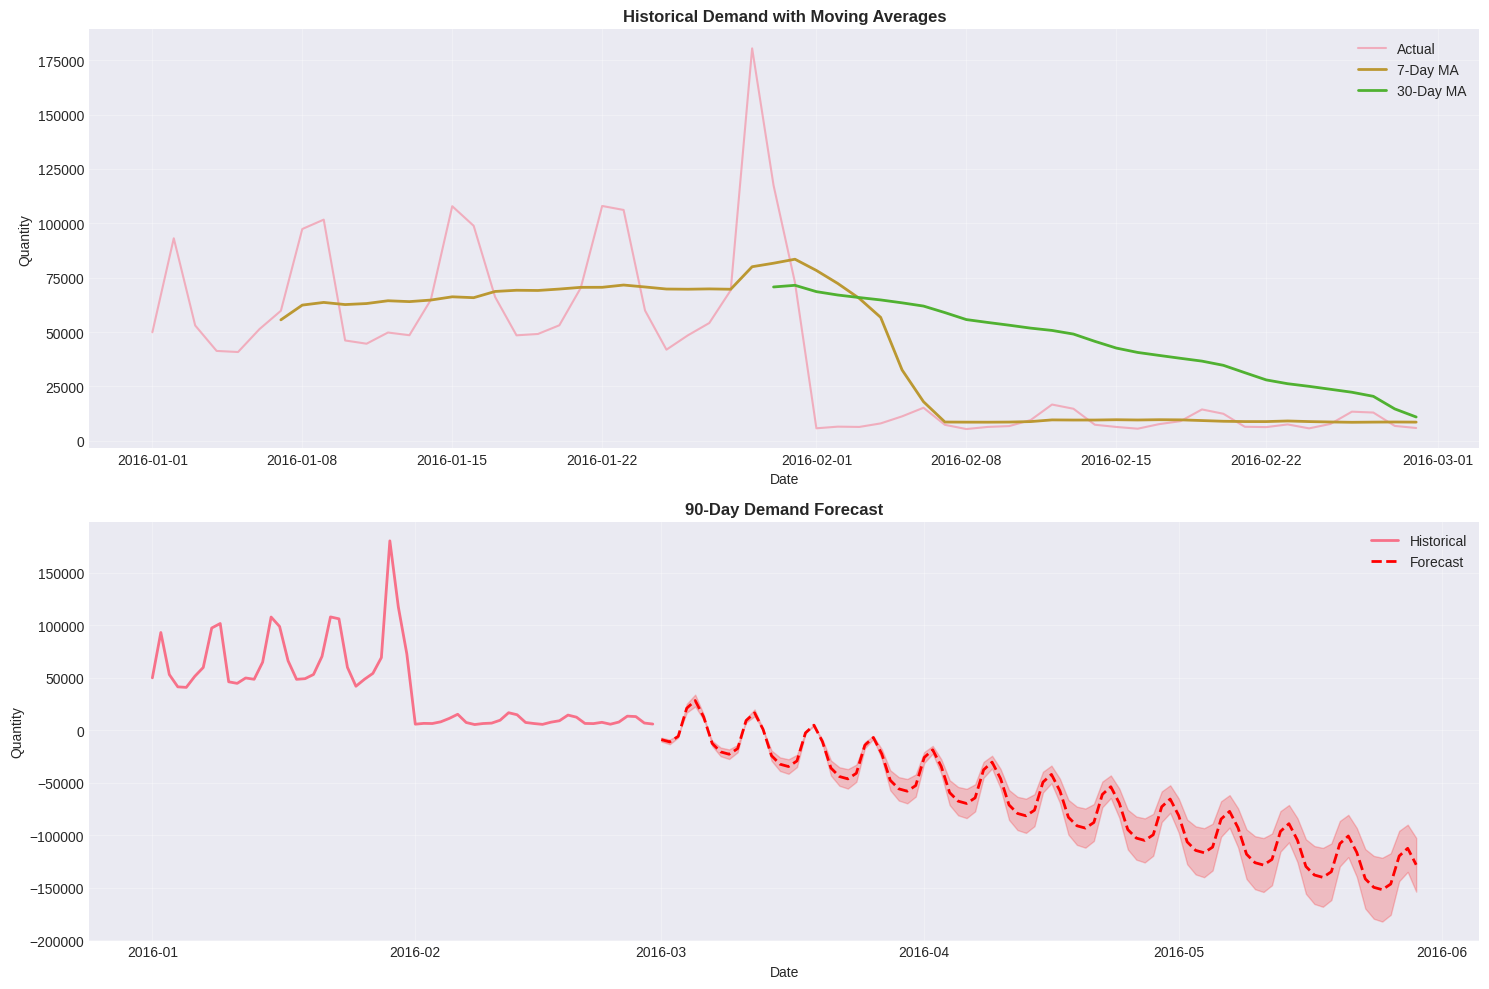


💡 Forecast Summary:
Avg Daily: -66071 units
Total (90d): -5946430 units

💰 Running EOQ Analysis...

💰 EOQ ANALYSIS
Order Cost: $100 | Holding Cost: 20.0% of value

📊 Top 15 Items by EOQ:


,item,annual_demand,eoq,orders_per_year,total_cost
5842,Smirnoff Watermelon,7895,2824.0,2.8,559.58
419,Baileys Espresso Creme,5369,2329.0,2.3,460.57
5581,Sauza Gold Tequila,5317,2317.0,2.3,459.38
5509,Sambuca Romana Liqueur,9059,2134.0,4.2,844.67
5812,Smirnoff 80 Proof,43423,2079.0,20.9,4179.49
5816,Smirnoff Blueberry Vodka,13181,2041.0,6.5,1295.60
1998,DK Burst Blustery Peppermint,3909,1987.0,2.0,396.71
6844,Yukon Jack,24037,1957.0,12.3,2457.90
5821,Smirnoff Green Apple Vodka,12968,1916.0,6.8,1356.93
2937,Goldschlager Cinnamon Schna,6544,1813.0,3.6,720.79


ValueError: cannot convert float NaN to integer

ValueError: need at least one array to concatenate

<Figure size 1500x1000 with 4 Axes>

In [5]:
# ============================================================================
# PART 11: PENDING DATA (Sales & Purchases)
# ============================================================================
# ⚠️ NOTE: Upload 'SalesFINAL12312016.csv' and 'PurchasesFINAL12312016.csv'
# to run EOQ, ROP, and Demand Forecasting below.

if 'SalesFINAL12312016.csv' in cleaned_data and 'PurchasesFINAL12312016.csv' in cleaned_data:

    # 3. DEMAND FORECASTING
    # using SalesFINAL12312016.csv
    print("\n📈 Running Demand Forecasting...")
    forecast_results = demand_forecasting(
        df=cleaned_data['SalesFINAL12312016.csv'],
        date_col='salesdate',
        qty_col='salesquantity'
    )

    # 4. EOQ ANALYSIS (Economic Order Quantity)
    # using SalesFINAL (for demand) and PurchasesFINAL (for price)
    # We need to merge price info or use sales price as proxy
    print("\n💰 Running EOQ Analysis...")
    eoq_results = eoq_analysis(
        df=cleaned_data['SalesFINAL12312016.csv'],
        item_col='description',
        demand_col='salesquantity',
        price_col='salesprice'
    )

    # 5. REORDER POINT ANALYSIS
    print("\n🚨 Running Reorder Point Analysis...")
    rop_results = reorder_point_analysis(
        df=cleaned_data['SalesFINAL12312016.csv'],
        item_col='description',
        demand_col='salesquantity'
    )

    # Generate Final Summary
    generate_executive_summary(abc_results, eoq_results, rop_results)

else:
    print("\n⚠️ WAITING FOR DATA: Upload 'SalesFINAL12312016.csv' and 'PurchasesFINAL12312016.csv' to run Forecasting and EOQ.")